In [1]:
FIGURES_PATH = 'out/figures/'
DATASETS_PATH = 'out/datasets/'

In [2]:
import pandas as pd
from datetime import datetime
import os
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from tqdm import tqdm

from helper import *

In [3]:
NROWS = None

In [4]:
data = pd.read_csv(DATASETS_PATH + 'data_processed.csv', nrows=NROWS).drop(columns=['Unnamed: 0'])
data['datetime'] = pd.to_datetime(data['datetime'])
data

,gid,transaction_key,store_id,product_id,line_item_price,line_item_cost,line_type,datetime,category_id,weekday,line_quantity
0,0,0,2,0,2990.0,2516.10,0,2022-04-18 12:22:18,NaN,0,1.0
1,1,1,3,1,1413.0,1206.73,1,2022-08-26 18:00:29,NaN,4,2.0
2,1,1,3,2,338.0,179.51,1,2022-08-26 18:00:29,NaN,4,4.0
3,1,1,3,3,1634.0,1402.83,1,2022-08-26 18:00:29,NaN,4,1.0
4,1,1,3,4,78.0,61.70,1,2022-08-26 18:00:29,NaN,4,40.0
...,...,...,...,...,...,...,...,...,...,...,...
7485222,168014,1429117,3,512,125.0,66.02,0,2022-08-25 16:28:55,NaN,3,1.0
7485223,168014,1429117,3,16155,74.0,40.00,0,2022-08-25 16:28:55,NaN,3,1.0
7485224,508132,1429118,3,7240,280.0,180.06,3,2023-03-16 18:40:45,NaN,3,1.0
7485225,508132,1429118,3,198,250.0,NaN,3,2023-03-16 18:40:45,NaN,3,1.0


### Функции вывода графиков

In [5]:
def scatter_prices(data, line_article_id):
    these_prices = data.loc[data['product_id'] == line_article_id][['line_item_price', 'datetime', 'line_quantity']]
    grouped_prices = these_prices.groupby(['line_item_price'])
    ans = grouped_prices['line_quantity'].apply(lambda x: x.sum())

    ans_cnt = grouped_prices['line_quantity'].apply(lambda x: len(x))
    cnt = (ans_cnt.array - ans_cnt.array.min()) / (ans_cnt.array.max() - ans_cnt.array.min())
    cnt *= 50

    prices, counts = ans.axes, ans.array

    fig1, ax1 = plt.subplots(figsize=(20, 10))
    fig2, ax2 = plt.subplots(figsize=(20, 10))

    fig1.suptitle('Items')
    fig2.suptitle('Buyers')

    ax1.set_xlabel("Price, RUR")
    ax1.set_ylabel("Count of items")
    ax1.grid(axis='x', which='major')

    ax1.set_title(
        str(line_article_id) + ' - ' + str(these_prices['line_quantity'].sum()))
    ax1.scatter(prices[0], counts, s=cnt, c=counts, cmap='cool')

    ax2.set_xlabel("Price, RUR")
    ax2.set_ylabel("Count of buyers")
    ax2.grid(axis='x', which='major')

    ax2.set_title(
        str(line_article_id) + ' - ' + str(these_prices['line_quantity'].sum()))
    ax2.scatter(prices[0], cnt, s=cnt, c=counts, cmap='cool')


    # plot = ax2.pcolor(counts)
    # fig2.colorbar(plot)

# scatter_prices(data, 15058563)


In [6]:
def scatter_mean_prices(data, ylim=None):
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.scatter(data.index, data['average_price'], s=0.2)

    x = data['average_price']
    m, s = x.mean(), x.std()

    ax.axhline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axhline(m + s, alpha=0.5, linestyle='--', color='r')
    ax.axhline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_ylim(bottom=0, top=ylim)
    ax.set_xlim(left=0)
    ax.set_xlabel('Users')
    ax.set_ylabel('Mean price')
    ax.set_title('Mean prices')

    ax.legend()
    plt.savefig(FIGURES_PATH + 'users_mean_prices')

In [7]:
def scatter_hist_of_prices(data, nbins=10, price_limit=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = data['average_price'].values
    m, s = x.mean(), x.std()


    ax.hist(x, bins=nbins, range=price_limit, histtype='bar', edgecolor='black', linewidth=1.1)
    ax.axvline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axvline(m + s, alpha=0.5, linestyle='--', color='r')

    ax.axvline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_xlabel('Mean price of purchases')
    ax.set_ylabel('Count of buyers')
    ax.set_title('Histogram of frequency')
    ax.legend()
    plt.savefig(FIGURES_PATH + 'users_hist')

In [8]:
def scatter_hist_of_products(data, nbins=10, price_limit=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = data['line_item_price'].values

    m, s = x.mean(), x.std()
    ax.hist(x, bins=nbins, range=price_limit, histtype='bar', edgecolor='black', linewidth=1.1)

    ax.axvline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axvline(m + s, alpha=0.5, linestyle='--', color='r')
    ax.axvline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_xlabel('Price of product')
    ax.set_ylabel('Count of products')
    ax.set_title('Histogram of frequency')

    ax.legend()
    plt.savefig(FIGURES_PATH + 'products_hist')

In [9]:
def scatter_hist_of_weekdays(data):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = data['weekday'].values

    ax.hist(x, bins=7, histtype='bar', edgecolor='black', linewidth=1.1)

    ax.set_xlabel('Weekday')
    ax.set_ylabel('Count of purchases')
    ax.set_title('Histogram of weekdays')
    ax.set_xticks([i for i in range(0, 7)], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation='vertical')

    ax.legend()
    plt.savefig(FIGURES_PATH + 'weekdays_hist')

In [10]:
def scatter_pie_of_prices(data, nbins=5, top_limit=10_000):
    fig, ax = plt.subplots(figsize=(20, 10))
    x, bin_edges = np.histogram(data['line_item_price'].values, bins=nbins, range=(0, top_limit))
    colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, len(x)))
    ax.pie(x, colors=colors, radius=2, center=(4, 4), labels=['<' + str(i) for i in bin_edges[1:]],
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, autopct='%1.1f%%')


    plt.savefig(FIGURES_PATH + 'pie_of_prices')

In [11]:
def plot_over_time(data):
    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    plt.ylabel('Count of products')
    plt.title('Product sales')

    dates = data['datetime'].dt.date.value_counts()
    dates_ma = dates.rolling(5).mean()
    dates_ma.plot(alpha=0.3, color='r')

    dates.plot()
    plt.savefig(FIGURES_PATH + 'plot_over_time')

In [12]:
def scatter_hist_over_time(data, nbins=None, plot_ma=False):
    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    plt.ylabel('Count of products')
    plt.title('Product sales')

    dates = data['datetime'].dt.date

    mi, ma = dates.min(), dates.max()

    opti_bins = (ma - mi).days
    if nbins is None:
        nbins = opti_bins
    dates.hist(bins=nbins, histtype='bar', edgecolor='black', linewidth=1.1)

    if plot_ma:
        ma = dates.value_counts().rolling(20).mean()
        ma.plot(color='r', alpha=0.4)


    plt.savefig(FIGURES_PATH + 'hist_over_time')



### Анализ

In [13]:
def get_date_info(data):
    data = data[['product_id', 'gid', 'datetime', 'weekday', 'line_item_price']]
    grouped_by_date = data.groupby(by='datetime')

    ans = grouped_by_date[['product_id']].apply(lambda x: x.nunique()).rename(columns={'product_id': 'unique_products'})

    ans['unique_users'] = grouped_by_date['gid'].apply(lambda x: x.nunique())

    ans['average_price'] = grouped_by_date['line_item_price'].apply(lambda x: np.mean(x.values))
    ans['median_price'] = grouped_by_date['line_item_price'].apply(lambda x: get_median(x))
    ans['average_quantity'] = grouped_by_date['line_quantity'].apply(lambda x: np.mean(x.values))
    ans['average_date_delta'] = grouped_by_date['datetime'].apply(lambda x: get_mean(get_time_delta(x)))

    return ans

In [14]:
def get_weekday_info(data):
    grouped_by_weekday = data.groupby(by='weekday')
    ans = grouped_by_weekday[['transaction_key']].apply(lambda x: x.nunique()).rename(columns={'transaction_key': 'unique_receipts'})

    ans['average_receipt_sum'] = grouped_by_weekday['line_item_price'].apply(lambda x: x.values.sum() / x.values.shape[0])
    ans['unique_users'] = grouped_by_weekday['gid'].apply(lambda x: x.nunique())
    return ans
    #
    # return ans

In [15]:
weekday_info = get_weekday_info(data)
weekday_info

,unique_receipts,average_receipt_sum,unique_users
weekday,,,
0,178542,607.040009,125710
1,191996,597.713571,133644
2,194665,595.864334,135253
3,195939,593.002387,135947
4,203323,597.205787,141181
5,244293,607.282917,167997
6,220361,620.455964,153835


In [16]:
# from helper import get_median

def get_product_info(data):
    data = data[['product_id', 'line_item_price', 'store_id', 'line_item_cost', 'datetime', 'line_quantity', 'gid']]
    grouped_by_product = data.groupby(by='product_id')

    ans = grouped_by_product[['gid']].apply(lambda x: x.nunique()).rename(columns={'gid': 'unique_users'})

    ans['average_price'] = grouped_by_product['line_item_price'].apply(lambda x: np.mean(x.values))
    ans['median_price'] = grouped_by_product['line_item_price'].apply(lambda x: get_median(x))
    ans['average_quantity'] = grouped_by_product['line_quantity'].apply(lambda x: np.mean(x.values))
    ans['average_date_delta'] = grouped_by_product['datetime'].apply(lambda x: get_mean(get_time_delta(x)))
    return ans


In [17]:
product_info = get_product_info(data)
product_info

,unique_users,average_price,median_price,average_quantity,average_date_delta
product_id,,,,,
0,121,2990.000000,2990.0,1.016260,1 days 02:00:43.967213114
1,2564,1435.979922,1458.0,2.073510,0 days 02:49:34.041140265
2,19,370.900000,338.0,3.200000,17 days 07:43:57.368421052
3,1556,1804.330152,1790.0,1.453116,0 days 04:53:37.616853932
4,92,76.666667,78.0,6.342857,2 days 13:23:45.384615384
...,...,...,...,...,...
94749,1,15.000000,15.0,2.000000,NaT
94750,1,175.000000,175.0,2.000000,NaT
94751,1,655.000000,655.0,1.000000,NaT


In [18]:
def get_user_info(data):
    """
    :param data: receipts - pandas.DataFrame
    :return: ans: info for every user - pandas.DataFrame
    """

    grouped_by_user = data[['gid', 'line_item_price', 'product_id']].groupby(by='gid')
    ans = grouped_by_user[['product_id']].apply(lambda x: x.nunique()).rename(columns={'product_id': 'unique_products'})
    ans['average_price'] = grouped_by_user['line_item_price'].apply(lambda x: np.mean(x.values))
    ans['quantile_0.25'] = grouped_by_user['line_item_price'].quantile(0.25)
    ans['median_price'] = grouped_by_user['line_item_price'].apply(lambda x: get_median(x))
    ans['quantile_0.75'] = grouped_by_user['line_item_price'].quantile(0.75)
    ans['quartile_range'] = ans['quantile_0.75'] - ans['quantile_0.25']
    ans['std'] = grouped_by_user['line_item_price'].std()
    # ans['average_date_delta'] = grouped_by_user['datetime'].apply(lambda x: get_mean(get_time_delta(x)))
    # ans['date_quartile_range'] = grouped_by_user['datetime'].apply(lambda x: get_quartile_range(get_time_delta(x)))
    return ans



In [19]:
user_info = get_user_info(data)
user_info

,unique_products,average_price,quantile_0.25,median_price,quantile_0.75,quartile_range,std
gid,,,,,,,
0,3,1018.666667,33.00,45.0,1517.50,1484.50,1707.266919
1,46,470.278261,86.75,175.5,502.00,415.25,815.889769
2,1,941.000000,941.00,941.0,941.00,0.00,0.000000
3,25,2322.194074,46.00,312.0,1284.00,1238.00,5192.818104
4,4,876.750000,237.50,369.5,1008.75,771.25,1202.269070
...,...,...,...,...,...,...,...
593443,3,1088.000000,263.00,458.0,1598.00,1335.00,1442.185841
593444,8,454.025000,129.80,390.5,620.50,490.70,433.137134
593445,2,3154.000000,1752.00,3154.0,4556.00,2804.00,3965.454829


In [20]:
def three_sigmas(ser):
    mean = ser.mean()
    std = ser.std()

    one_sigma = ser.loc[ser > mean - std].loc[ser < mean + std].shape[0] / ser.shape[0]
    two_sigma = ser.loc[ser > mean - 2 * std].loc[ser < mean + 2 * std].shape[0] / ser.shape[0]
    three_sigma = ser.loc[ser > mean - 3 * std].loc[ser < mean + 3 * std].shape[0] / ser.shape[0]
    return one_sigma, two_sigma, three_sigma

In [21]:
user_info.apply(three_sigmas)

,unique_products,average_price,quantile_0.25,median_price,quantile_0.75,quartile_range,std
0,0.911317,0.950006,0.961161,0.955128,0.947891,0.953738,0.811377
1,0.960482,0.976832,0.980017,0.977487,0.975708,0.979248,0.841585
2,0.979890,0.986252,0.988078,0.986484,0.986071,0.988316,0.851788


In [22]:
product_info.apply(three_sigmas)

,unique_users,average_price,median_price,average_quantity,average_date_delta
0,0.984602,0.939454,0.940013,0.982650,0.813971
1,0.994048,0.970714,0.971009,0.995219,0.859911
2,0.996992,0.982956,0.983083,0.997615,0.876649


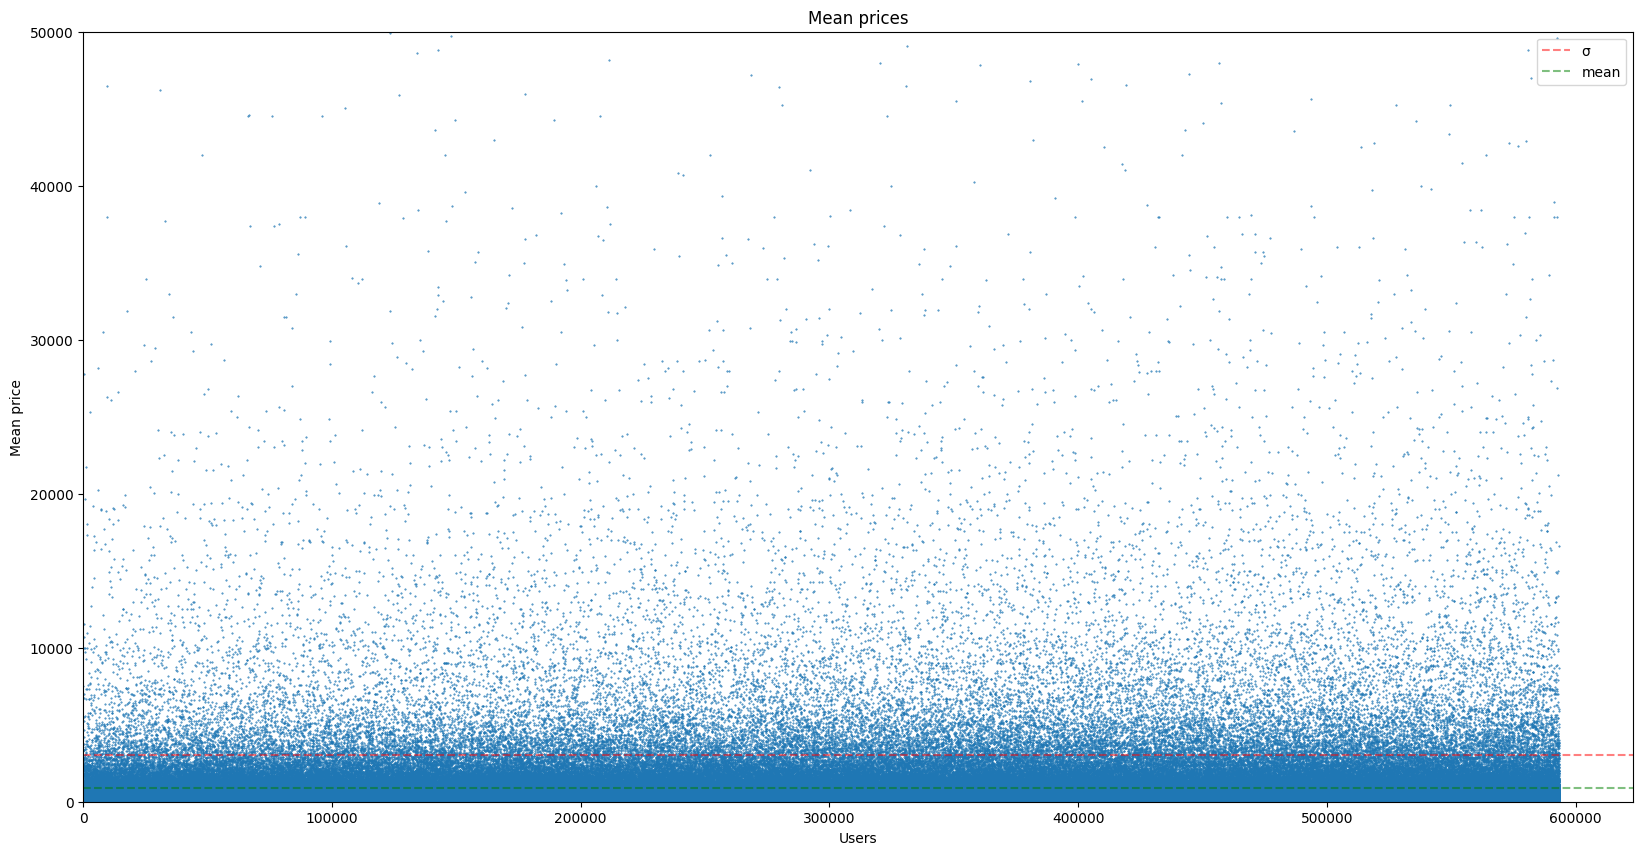

In [23]:
scatter_mean_prices(user_info, ylim=50_000)

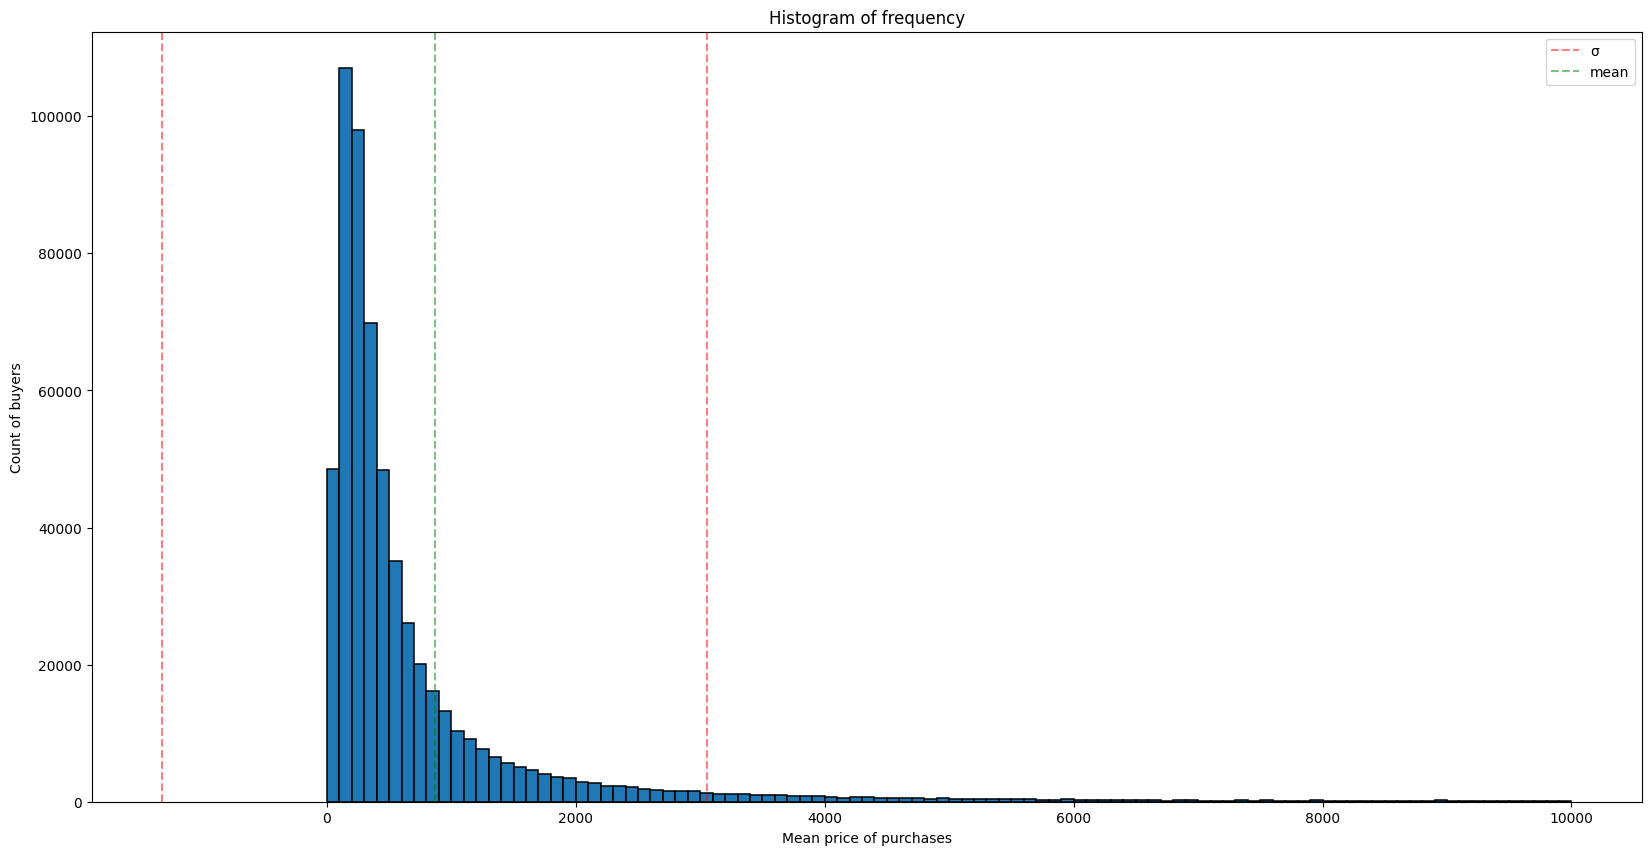

In [24]:
scatter_hist_of_prices(user_info, nbins=100, price_limit=(0, 10_000))

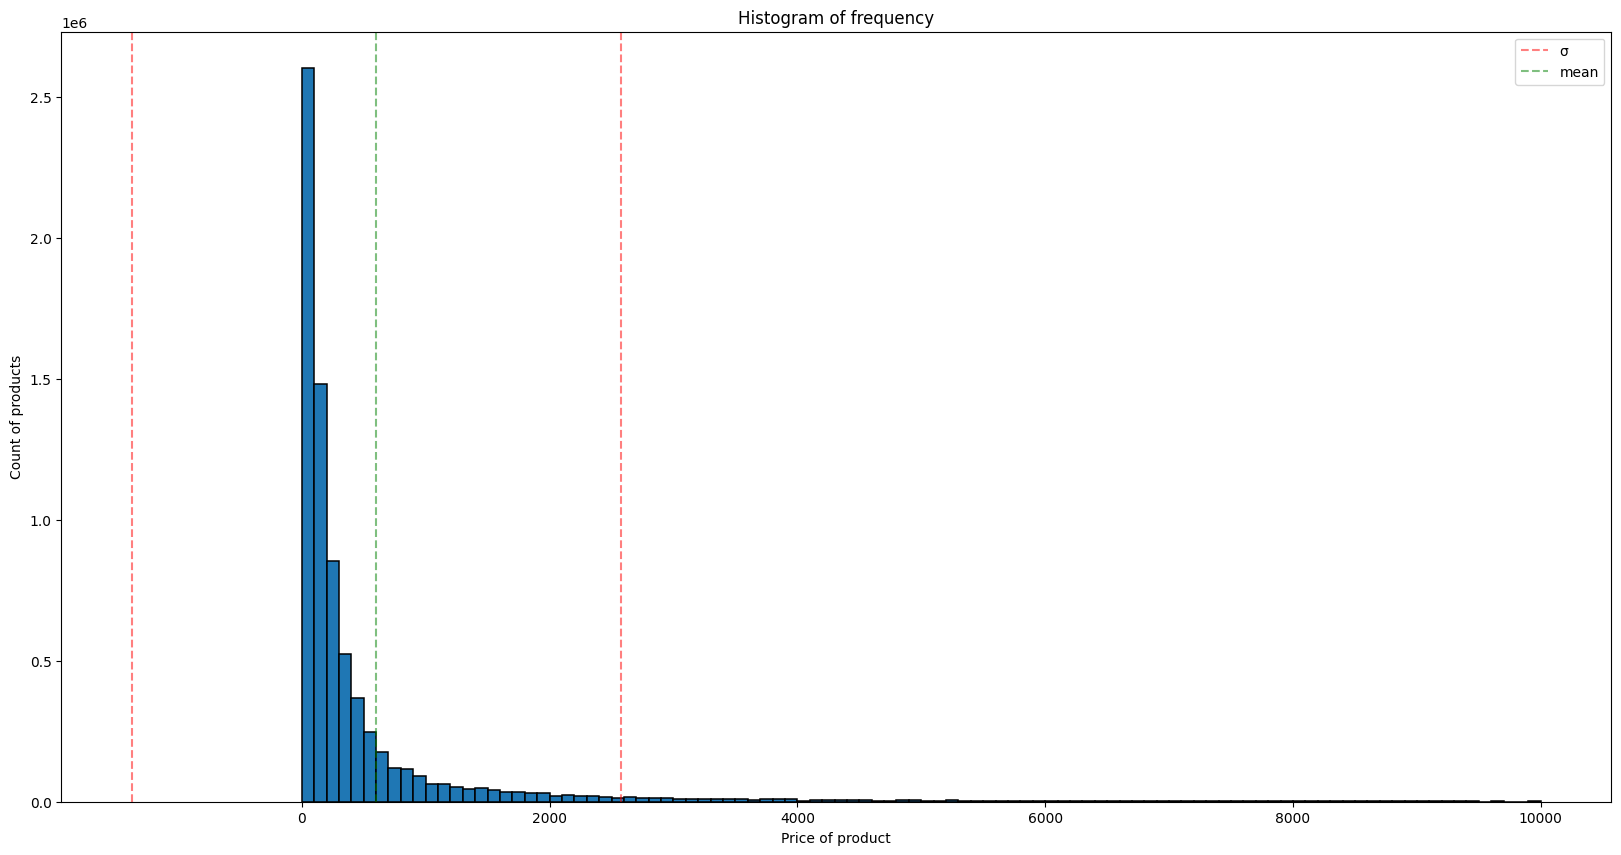

In [25]:
scatter_hist_of_products(data, nbins=100, price_limit=(0, 10_000))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


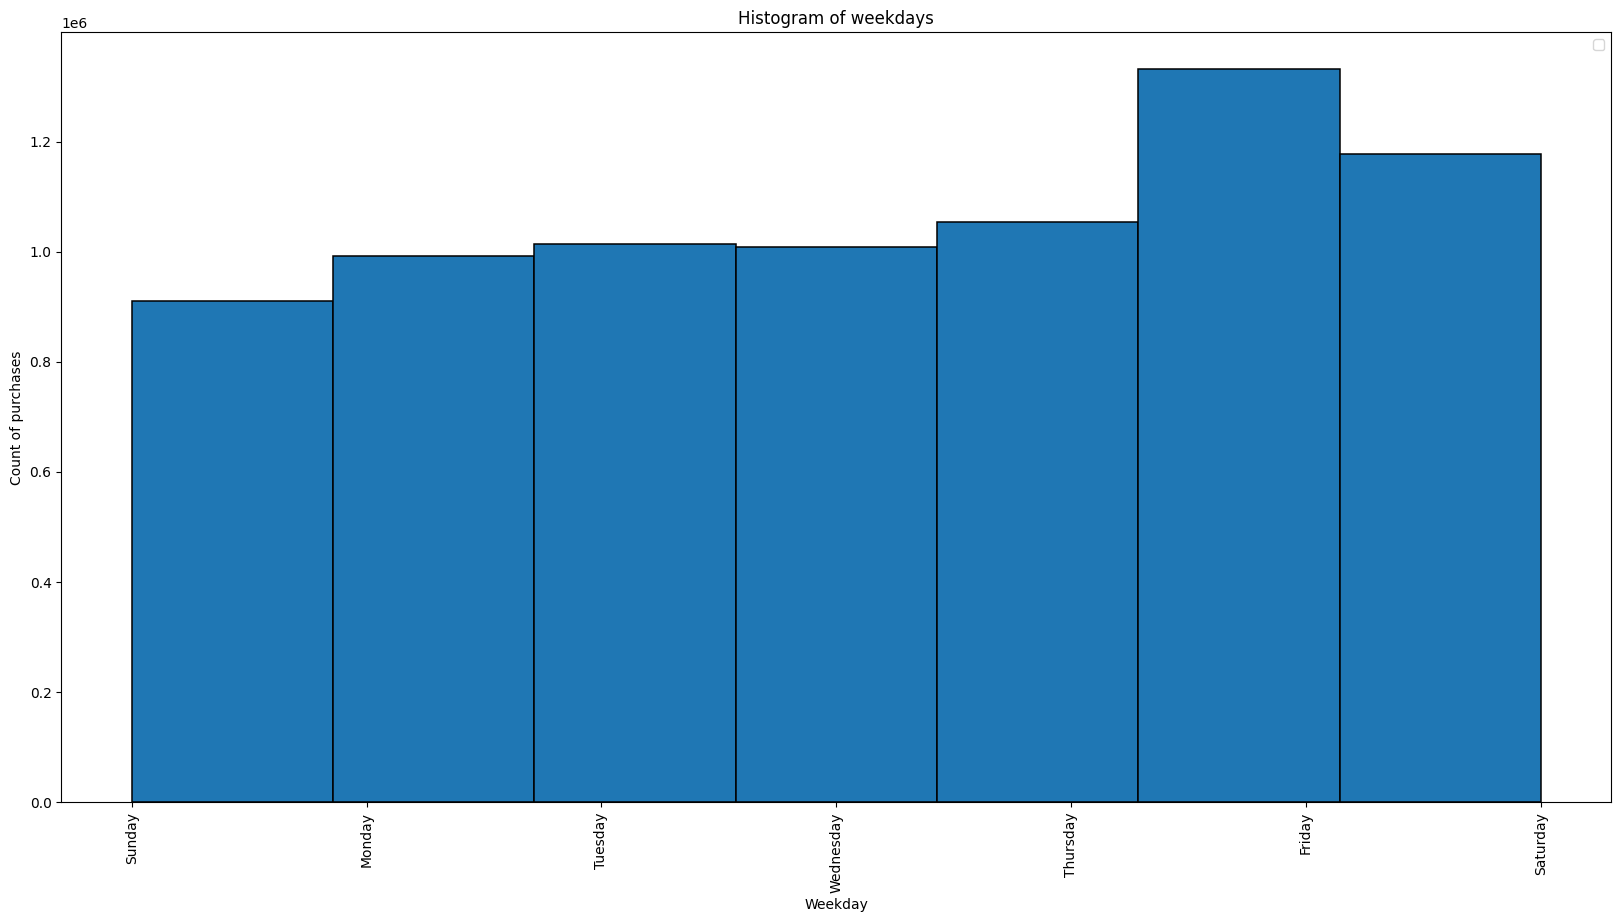

In [26]:
scatter_hist_of_weekdays(data)

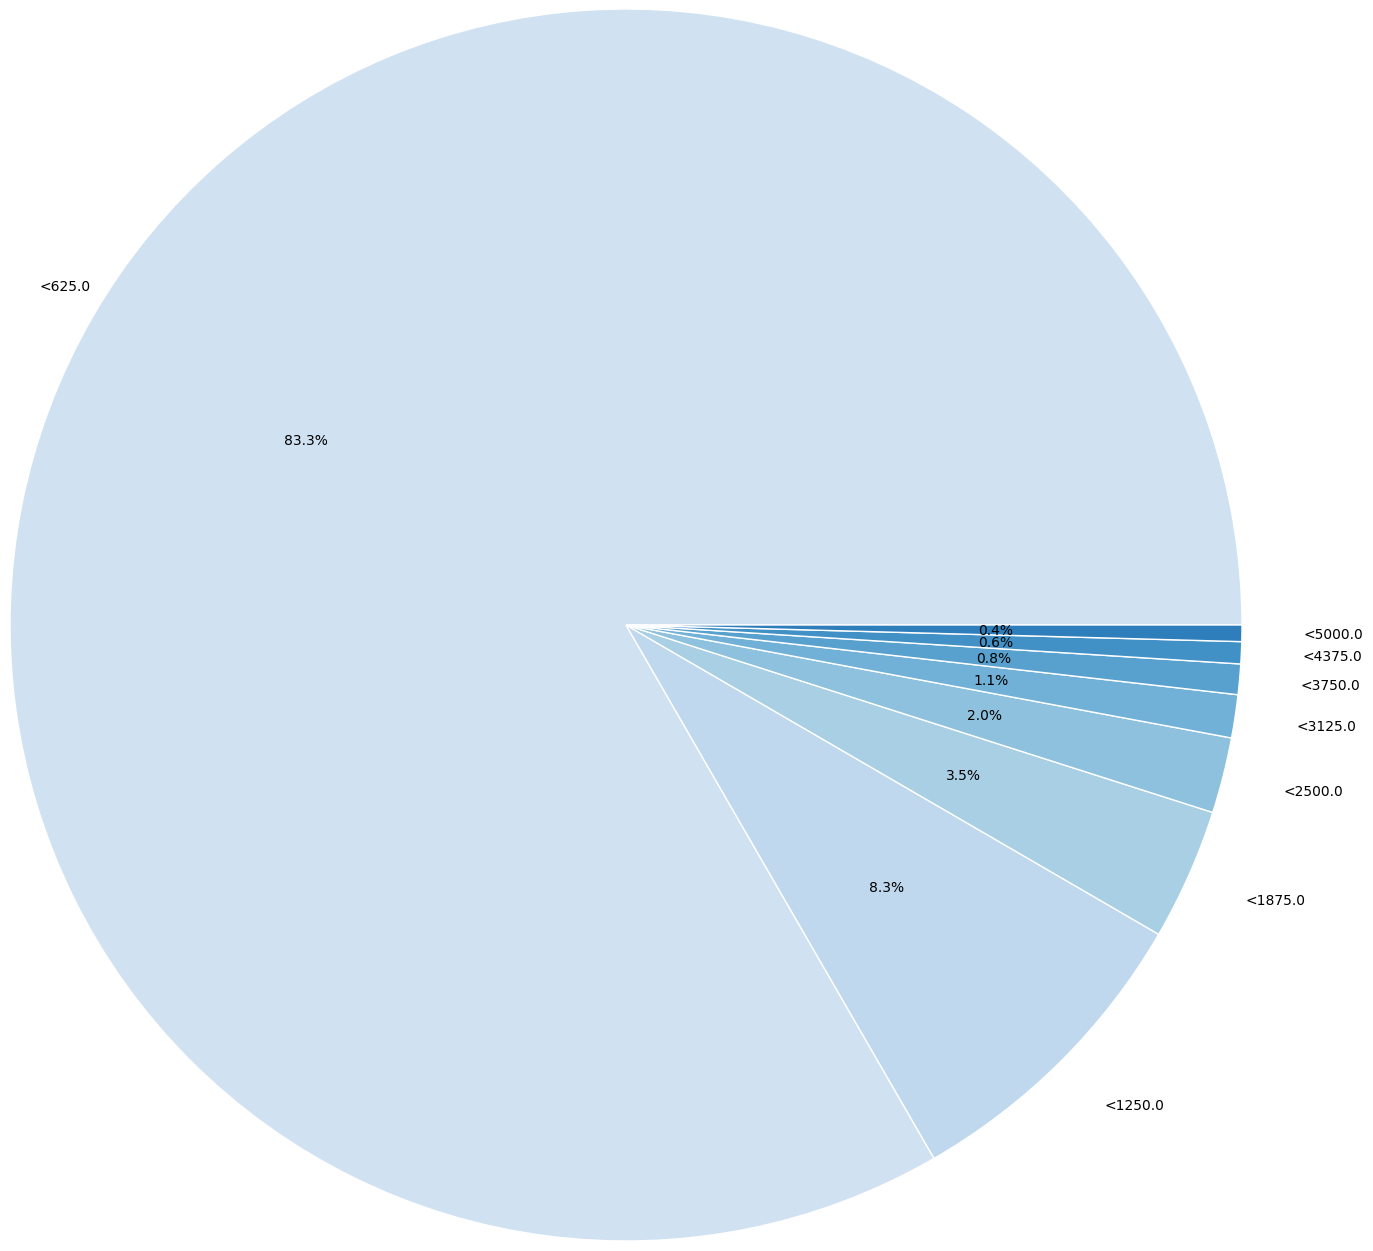

In [27]:
scatter_pie_of_prices(data, nbins=8, top_limit=5_000)

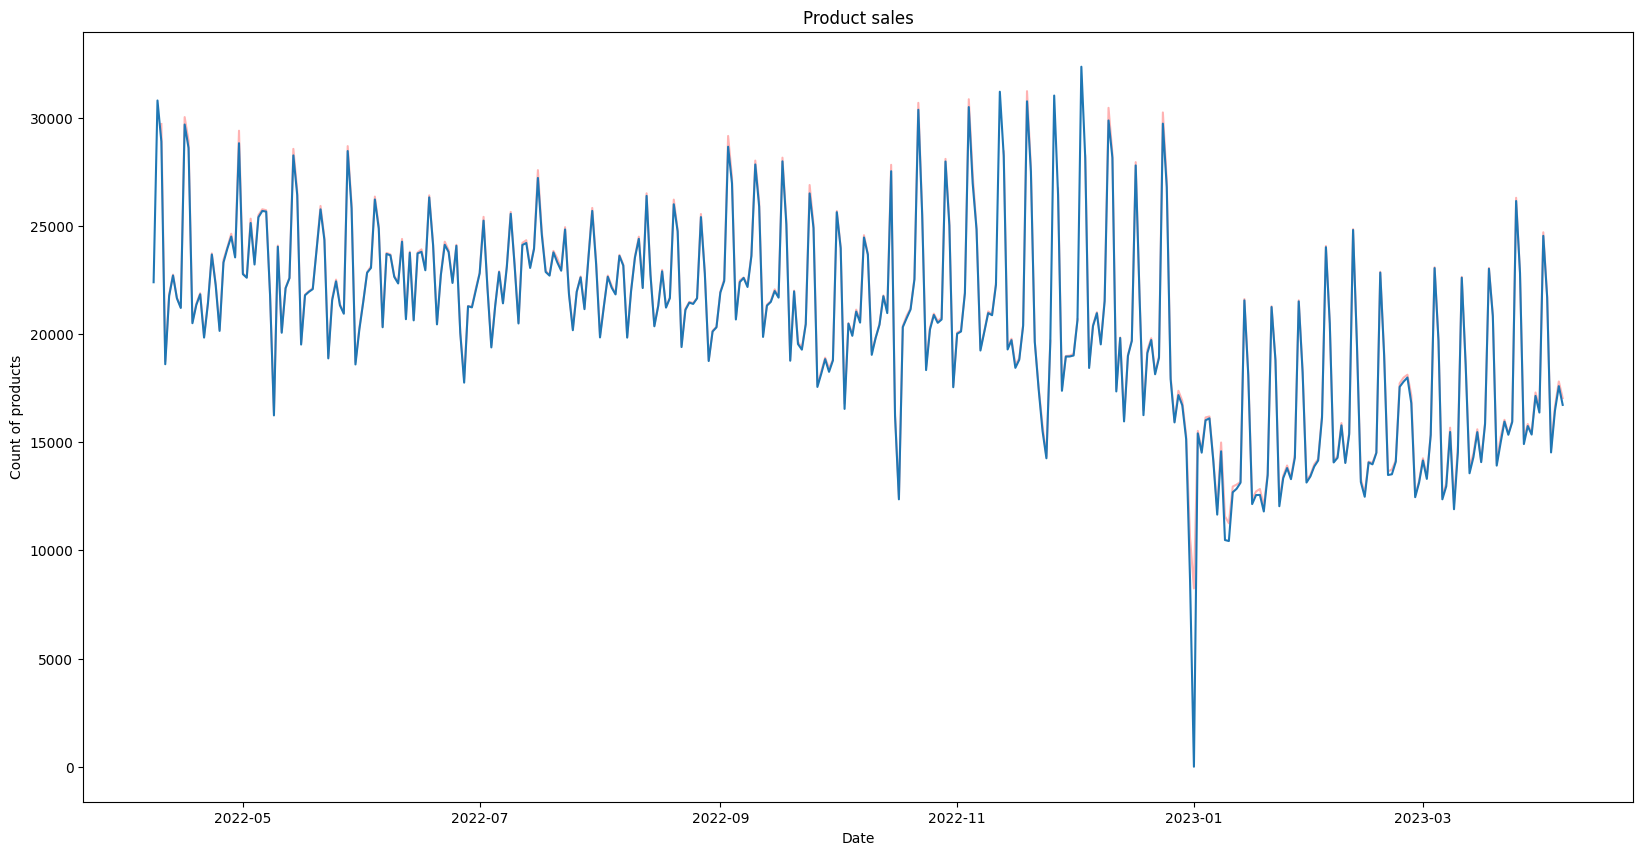

In [28]:
plot_over_time(data)

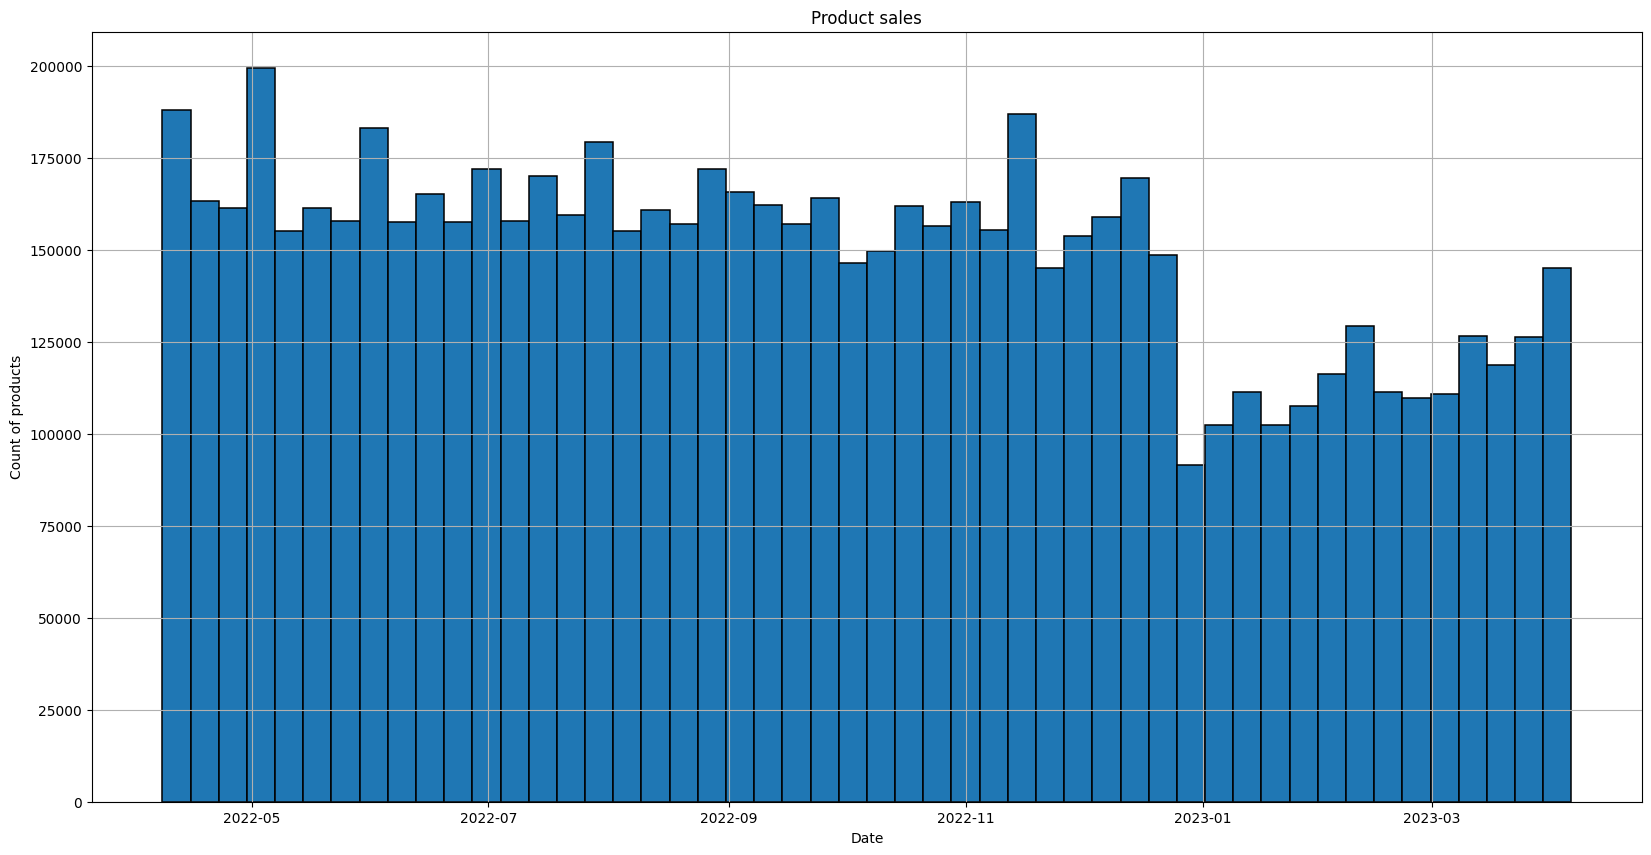

In [29]:
scatter_hist_over_time(data, nbins=50, plot_ma=False)

### Прогнозирование

In [31]:
# purchases = get_user_purchases(data, batch_size=100_000)
# purchases

In [32]:
# three_sigmas(purchases)

### Временные ряды

In [34]:
class Period:
    def __init__(self, date_from, date_to, date_type='%d.%m.%y'):
        self.start = datetime.strptime(date_from, date_type)
        self.end = datetime.strptime(date_to, date_type)

    def is_in(self, date):
        return self.start <= date <= self.end

    def includes(self, data):
        return data.loc[data.datetime >= self.start].loc[data.datetime <= self.end]

In [35]:
# def get_from_to(data, date_from, date_to, date_type='%d/%m/%y'):
#     return data.loc[data.datetime >= datetime.strptime(date_from, date_type)].loc[data.datetime <= datetime.strptime(date_to, date_type)]

def get_from_to(data, date_period):
    return date_period.includes(data)

def get_by_weekday(data, weekday):
    i = 0
    for ind in weekday_dict:
        if weekday == weekday_dict[ind]:
            i = ind
    return data.loc[data.weekday == i]

def sort_by_date(data):
    return data.sort_values(by=['datetime'])


# sort_by_date(get_from_to(data, '01.04.22', '20.12.22', '%d.%m.%y'))
# get_by_weekday(data, 'Четверг')

In [36]:

# sort_by_date(get_from_to(data, Period('01.04.22', '20.12.22', '%d.%m.%y')))

### Эластичность спроса по цене

In [37]:
def get_elasticity_over_periods(data, product_id, date_period_1, date_period_2):
    data = data[['product_id', 'line_item_price', 'datetime']].loc[data.product_id == product_id]

    data_1 = date_period_1.includes(data)
    data_2 = date_period_2.includes(data)

    count_1 = data_1.shape[0]
    count_2 = data_2.shape[0]

    price_1 = data_1['line_item_price'].mean()
    price_2 = data_2['line_item_price'].mean()

    e = ((count_2 - count_1) / count_1) / ((price_2 - price_1) / price_1)
    return e

In [38]:
def get_dates_when_price_changed(data, product_id):
    data = data[['product_id', 'line_item_price', 'datetime']].loc[data.product_id == product_id]
    when_changed = data['line_item_price'].shift() != data['line_item_price']#['datetime']
    return when_changed

In [39]:
# get_elasticity_over_periods(data, 18785635, Period('19.10.21', '20.12.22'), Period('20.12.22', '22.12.23'))

In [40]:
# get_dates_when_price_changed(data, 18785635)

In [41]:
import pandas_profiling
# prof = data.profile_report(progress_bar=True, explorative=True)

/tmp/ipykernel_15048/3051787757.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [42]:
# prof = pandas_profiling.ProfileReport(data)
# prof.to_file(output_file='out/output.html')